In [1]:
!pip install kagglehub

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from tqdm import tqdm
import numpy as np
import random
import math
import os

device = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available()
                      else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Import Dataset from Kaggle

Dataset: ASL (American Sign Language) Alphabets


In [3]:
import kagglehub

path = kagglehub.dataset_download("grassknoted/asl-alphabet")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/asl-alphabet


In [4]:
asl_image_root = os.path.join(path, "asl_alphabet_train", "asl_alphabet_train")
print("Classes:", sorted(os.listdir(asl_image_root)[:]))


Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


### Preprocess and visualize dataset

In [5]:
from torch.utils.data import Subset
from collections import defaultdict
import numpy as np

def create_subset_fast(dataset, samples_per_class, seed=0, transform=None):
    """
    Build a balanced subset quickly by picking indices from
    `dataset.targets` (a plain list of labels) instead of
    iterating through `__getitem__`, which would open every image.

    Args
    ----
    dataset : torchvision.datasets.ImageFolder
    samples_per_class : int
        How many images of each class to keep.
    seed : int
        Reproducible RNG seed for the sampling.
    transform : callable or None
        If given, replace dataset.transform **after** the indices
        are chosen. (Same behaviour as your original code.)

    Returns
    -------
    torch.utils.data.Subset
        A subset of the original ImageFolder.
    """
    rng = np.random.default_rng(seed)

    label_to_indices = defaultdict(list)
    for idx, label in enumerate(dataset.targets):
        label_to_indices[label].append(idx)

    subset_indices = []
    for label, idxs in label_to_indices.items():
        if len(idxs) < samples_per_class:
            raise ValueError(
                f"Not enough samples in class {label} "
                f"(has {len(idxs)}, requested {samples_per_class})"
            )
        subset_indices.extend(
            rng.choice(idxs, samples_per_class, replace=False)
        )

    if transform is not None:
        dataset.transform = transform

    return Subset(dataset, subset_indices)


In [6]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

asl_dataset = datasets.ImageFolder(root=asl_image_root, transform=transform)

# i
dataloader = DataLoader(
    asl_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=min(8, os.cpu_count()),
    pin_memory=(device.type == "cuda"),
    persistent_workers=True,
    prefetch_factor=2,
)

In [7]:
img_tensor, label = asl_dataset[0]
img_size = img_tensor.shape[1]
num_channel = img_tensor.shape[0]
class_names = asl_dataset.classes
num_classes = len(class_names)

print("Image shape (C, H, W):", img_tensor.shape)
print("Number of channels:", num_channel)
print("Number of casses: ", num_classes)
print("Class labels:", class_names)

Image shape (C, H, W): torch.Size([3, 64, 64])
Number of channels: 3
Number of casses:  29
Class labels: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


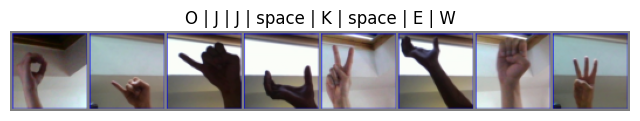

In [8]:

def imshow(img, title):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(8, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis("off")
    plt.show()

data_iter = iter(dataloader)
images, labels = next(data_iter)

imshow(torchvision.utils.make_grid(images[:8]), title=" | ".join([class_names[i] for i in labels[:8]]))


###  Define Forward and Reverse Noise Schedules

In [9]:
# Defines how noise increases each step (betas)
# alphas_hat represents cumulative product, controlling noising rate
# T is the total number of timesteps (also called noise steps or diffusion steps) used in the forward and reverse diffusion process.

import torch.nn as nn
import math, torch

# ----- diffusion schedule (unchanged) -----
T      = 500
betas  = torch.linspace(1e-4, 0.02, T).to(device)
alphas = 1. - betas
alphas_hat = torch.cumprod(alphas, dim=0)

### Utility functions

In [10]:


def timestep_embedding(t, dim):
    half = dim // 2
    freqs = torch.exp(
        torch.arange(half, device=device) * -(math.log(10000)/ (half - 1))
    )
    emb = t[:, None].float() * freqs[None, :]
    return torch.cat([emb.sin(), emb.cos()], dim=-1)

def noise_images(x, t):
    noise = torch.randn_like(x)
    sqrt_a_hat = alphas_hat[t][:, None, None, None].sqrt()
    sqrt_one_minus = (1 - alphas_hat[t])[:, None, None, None].sqrt()
    return sqrt_a_hat * x + sqrt_one_minus * noise, noise

### Define U-Net Model

In [11]:


# ---------- U-Net ----------
class ResBlock(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.block = nn.Sequential(
            nn.GroupNorm(8, c_in),
            nn.SiLU(),
            nn.Conv2d(c_in, c_out, 3, padding=1),
            nn.GroupNorm(8, c_out),
            nn.SiLU(),
            nn.Conv2d(c_out, c_out, 3, padding=1),
        )
        self.skip = nn.Conv2d(c_in, c_out, 1) if c_in != c_out else nn.Identity()

    def forward(self, x):
        return self.block(x) + self.skip(x)

class ConditionalUNet(nn.Module):
    def __init__(self, num_classes, img_size,
                 in_ch=1, base=64, time_emb_dim=32, label_dim=32):
        super().__init__()
        self.img_size = img_size

        # embeddings -------------------------------------------------------
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, base),
            nn.SiLU(),
            nn.Linear(base, base),
        )
        self.label_emb = nn.Embedding(num_classes, label_dim)

        in_channels = in_ch + base + label_dim          # 1 + 64 + 32 = 97
        self.in_proj = nn.Conv2d(in_channels, base, 3, padding=1)

        # encoder ----------------------------------------------------------
        self.enc1 = ResBlock(base,     base)
        self.enc2 = ResBlock(base,     base*2)
        self.down = nn.MaxPool2d(2)
        self.enc3 = ResBlock(base*2,   base*4)

        # bottleneck -------------------------------------------------------
        self.mid  = ResBlock(base*4,   base*4)

        # decoder ----------------------------------------------------------
        self.up3  = nn.ConvTranspose2d(base*4, base*2, 2, 2)
        self.dec3 = ResBlock(base*2,   base*2)
        self.up2  = nn.ConvTranspose2d(base*2, base,   2, 2)
        self.dec2 = ResBlock(base,     base)
        self.out  = nn.Conv2d(base, in_ch, 1)

    def forward(self, x, t, y):
        t_emb = timestep_embedding(t, self.time_mlp[0].in_features)
        t_emb = self.time_mlp(t_emb).unsqueeze(-1).unsqueeze(-1)
        lbl   = self.label_emb(y).unsqueeze(-1).unsqueeze(-1)

        t_emb = t_emb.expand(-1, -1, self.img_size, self.img_size)
        lbl   = lbl.expand(-1, -1, self.img_size, self.img_size)

        x = torch.cat([x, t_emb, lbl], dim=1)
        x = self.in_proj(x)

        e1 = self.enc1(x)
        e2 = self.enc2(self.down(e1))
        e3 = self.enc3(self.down(e2))
        m  = self.mid(e3)
        d3 = self.up3(m) + e2
        d3 = self.dec3(d3)
        d2 = self.up2(d3) + e1
        d2 = self.dec2(d2)
        return self.out(d2)


In [12]:
@torch.no_grad()
def sample(model, y, n=1, img_size=64):
    model.eval()
    y = y if y.dim() else y.unsqueeze(0)
    if y.shape[0] != n:
        y = y.repeat(n)

    x = torch.randn((n, num_channel, img_size, img_size), device=device)

    for i in reversed(range(T)):
        t = torch.full((n,), i, device=device, dtype=torch.long)
        pred_noise = model(x, t, y)
        alpha, a_hat, beta = alphas[i], alphas_hat[i], betas[i]
        noise = torch.randn_like(x) if i > 0 else torch.zeros_like(x)
        x = (1/alpha.sqrt()) * (x - (1-alpha)/(1-a_hat).sqrt() * pred_noise) \
            + beta.sqrt() * noise

    return (x.clamp(-1, 1) + 1) / 2              # [0,1]

### Training

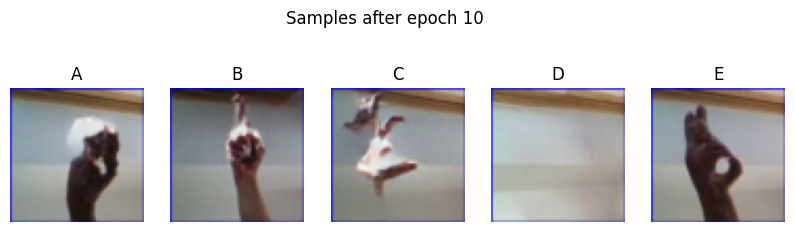

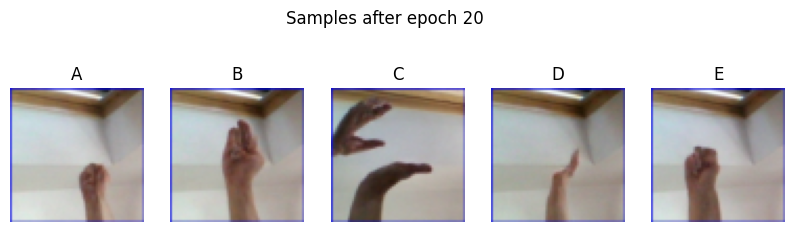

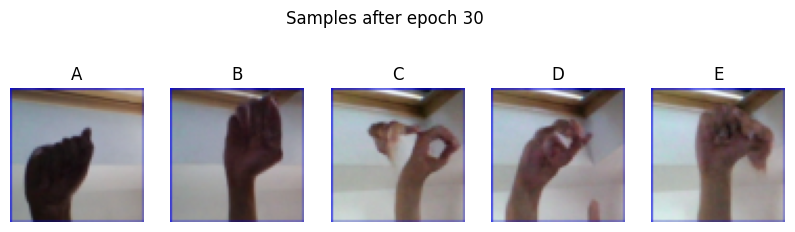

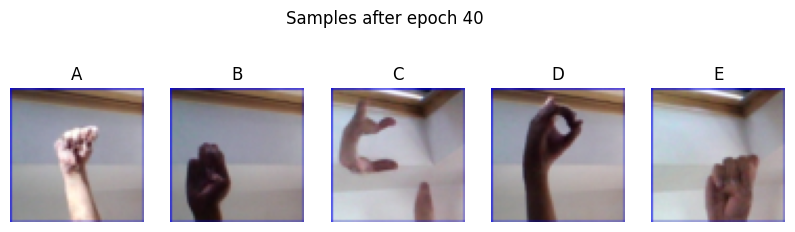

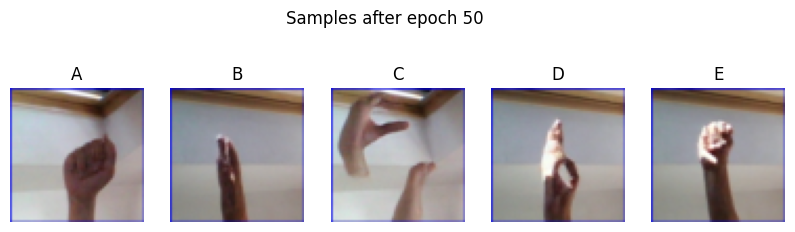

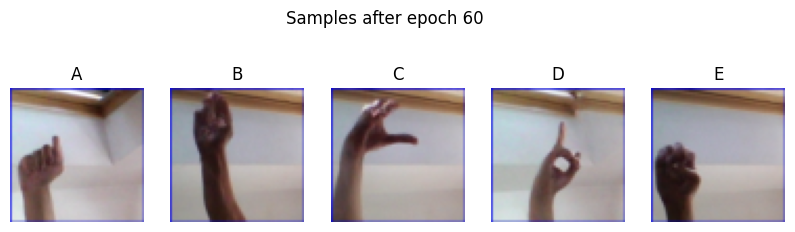

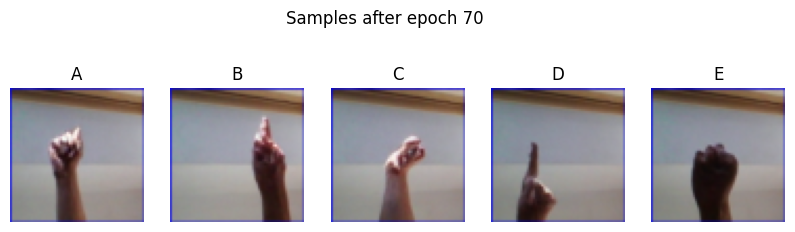

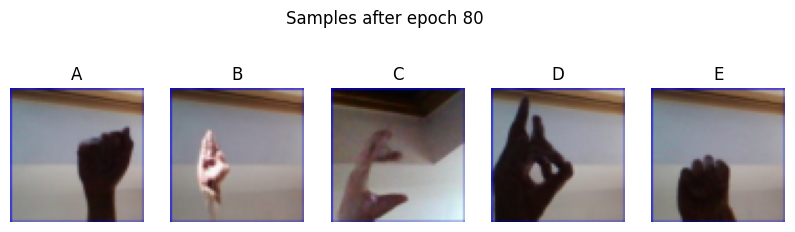

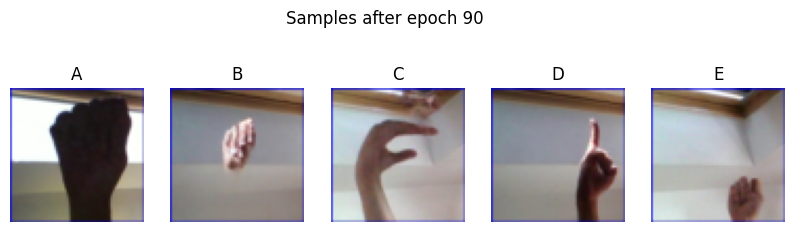

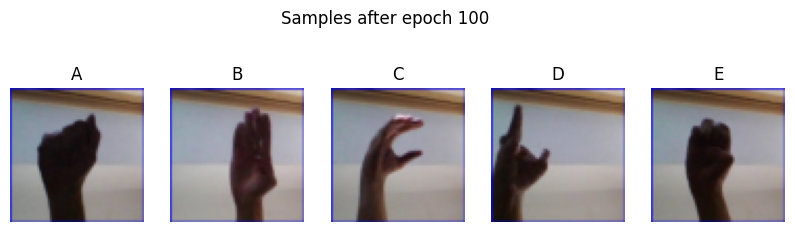

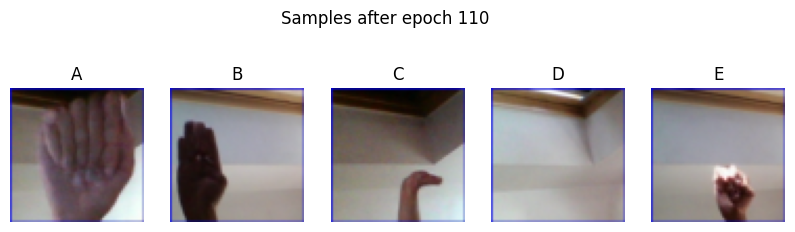

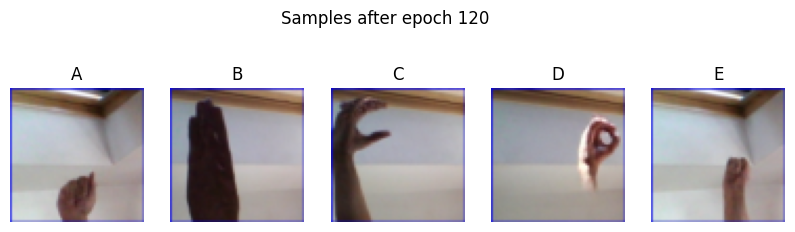

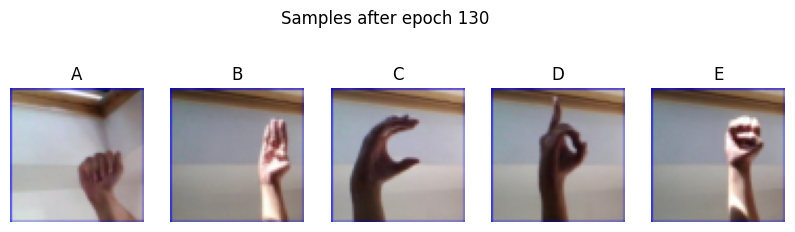

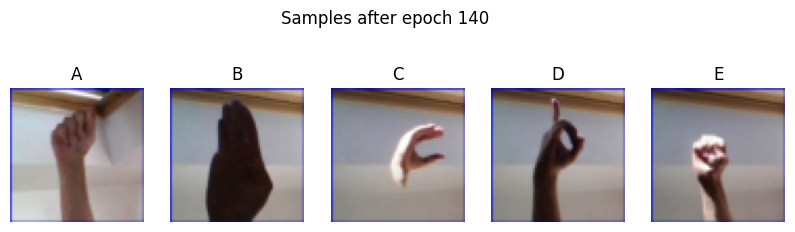

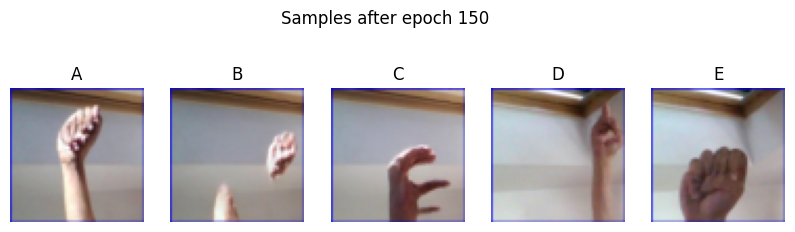

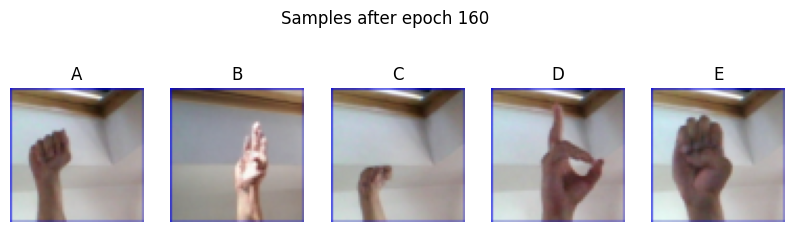

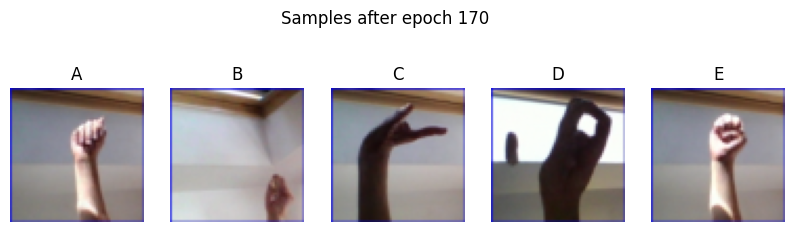

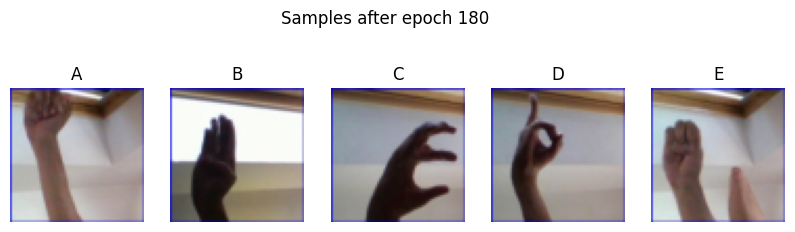

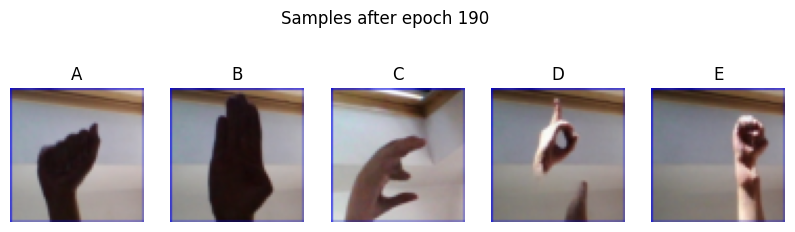

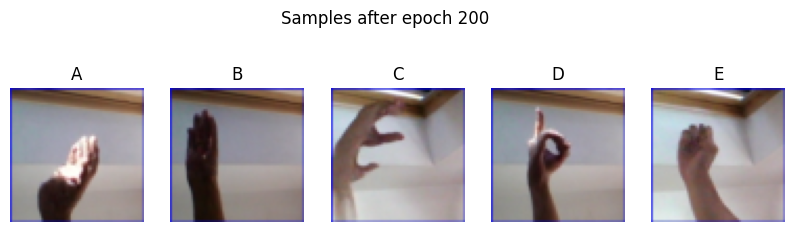

CPU times: user 7h 4min 42s, sys: 9min 59s, total: 7h 14min 41s
Wall time: 6h 57min 41s


In [13]:
%%time

# ---------- training ----------
num_channel = 3
model = ConditionalUNet(num_classes, img_size, in_ch=num_channel).to(device)
opt   = torch.optim.Adam(model.parameters(), lr=2e-4)
loss_fn = nn.MSELoss()
num_epochs = 200
log_every  = num_epochs // 20

for epoch in range(num_epochs):
    model.train()
    for x, y in (pbar := tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device)
        t = torch.randint(0, T, (x.size(0),), device=device)
        x_noisy, noise = noise_images(x, t)
        pred = model(x_noisy, t, y)

        loss = loss_fn(pred, noise)
        opt.zero_grad(); loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}  loss={loss.item():.4f}")

    # ----- visual check every few epochs -----
    if (epoch+1) % log_every == 0:
        model.eval()
        fig, axs = plt.subplots(1, 5, figsize=(10, 3))
        for i in range(5):
            label = torch.tensor([i], device=device)
            img   = sample(model, y=label, n=1).cpu().squeeze(0)  # (C,H,W)
            if num_channel == 1:
                axs[i].imshow(img.squeeze(), cmap="gray")
            else:
                axs[i].imshow(img.permute(1, 2, 0).numpy())
            axs[i].axis('off'); axs[i].set_title(class_names[i])
        plt.suptitle(f"Samples after epoch {epoch+1}")
        plt.show()

### Visualize Generated image

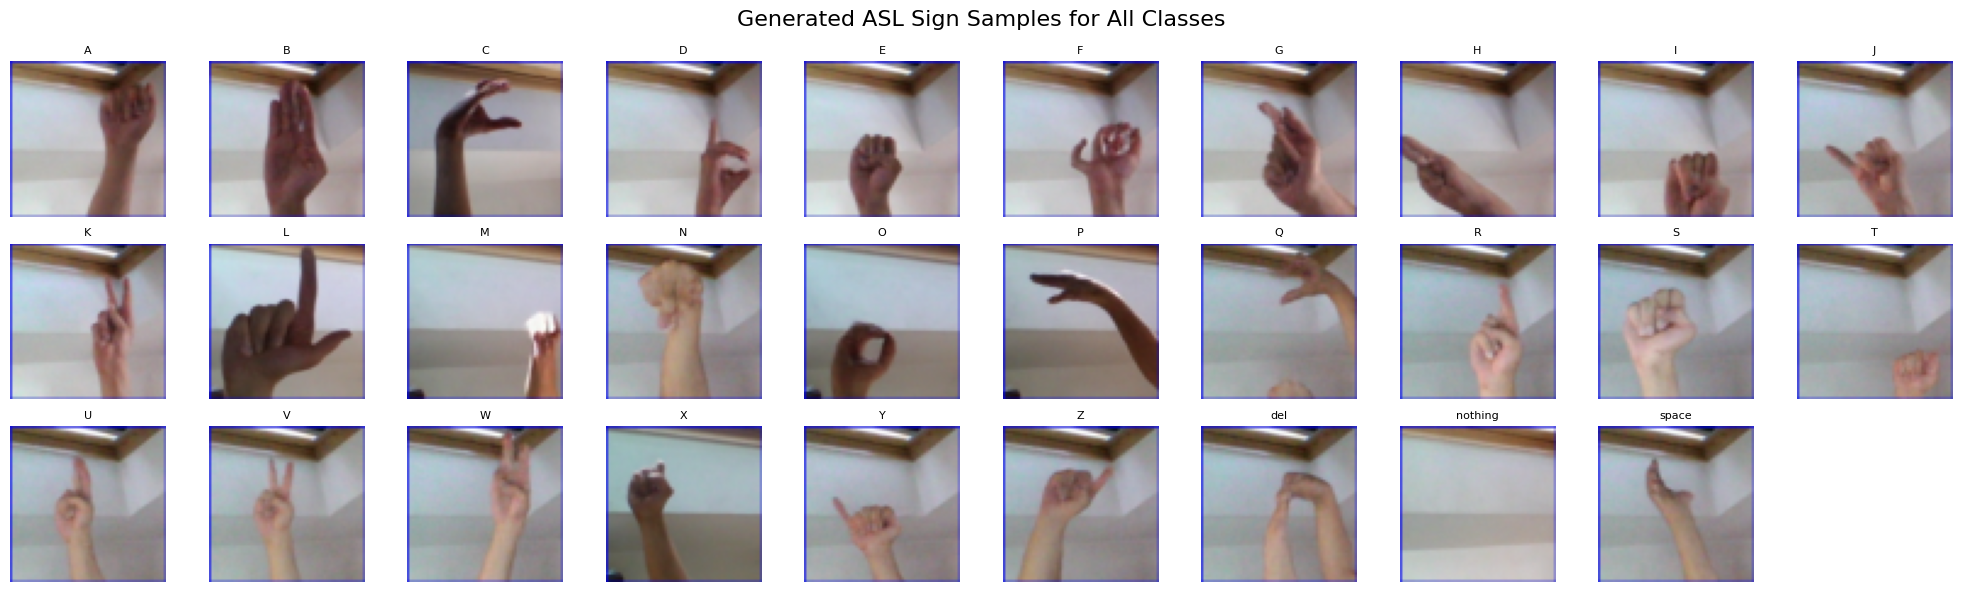

In [14]:
n_classes_to_show = len(class_names)
fig_rows = math.ceil(n_classes_to_show / 10)
fig, axs = plt.subplots(fig_rows, 10, figsize=(20, 2 * fig_rows))

axs = axs.flatten()

for i in range(n_classes_to_show):
    y = torch.tensor([i], device=device)
    img = sample(model, y=y, n=1).cpu().squeeze(0)

    if num_channel == 1:
        axs[i].imshow(img.squeeze(), cmap="gray")
    else:
        axs[i].imshow(img.permute(1, 2, 0).numpy())

    axs[i].axis('off')
    axs[i].set_title(class_names[i], fontsize=8)

for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.suptitle("Generated ASL Sign Samples for All Classes", fontsize=16)
plt.tight_layout()
plt.show()


In [15]:
torch.save(model.state_dict(), "conditional_unet.pth")